In [7]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# Download necessary NLTK resources
nltk.download('punkt')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Load dataset
file_path = "/kaggle/input/chatbotdata/chatbot_build.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Convert text to lowercase
df["user_message"] = df["user_message"].str.lower()

# Remove special characters
df["user_message"] = df["user_message"].apply(lambda x: re.sub(r"[^a-zA-Z0-9\s]", "", x))

# Display first few rows
df.head()


,intent,user_message,bot_response,keywords
0,greeting,hello,Hello! How can I assist you today?,hello
1,greeting,hi,Hi there! What can I help you with?,hi
2,greeting,hey,Hey! Need any help?,hey
3,goodbye,bye,Goodbye! Have a great day!,bye
4,goodbye,see you,See you soon! Feel free to return if you need ...,see


In [3]:
# Convert user messages into numerical form using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["user_message"])

# Encode intent labels into numbers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["intent"])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Define the model
model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(len(df["intent"].unique()), activation="softmax")
])

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
history = model.fit(X_train.toarray(), y_train, epochs=50, batch_size=8, validation_data=(X_test.toarray(), y_test))


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - accuracy: 0.4583 - loss: 1.0752 - val_accuracy: 0.6000 - val_loss: 1.0845
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5833 - loss: 1.0425 - val_accuracy: 0.6000 - val_loss: 1.0723
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - loss: 0.9469 - val_accuracy: 0.6000 - val_loss: 1.0586
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5000 - loss: 1.0204 - val_accuracy: 0.6000 - val_loss: 1.0465
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8333 - loss: 0.8565 - val_accuracy: 0.6000 - val_loss: 1.0356
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6667 - loss: 0.9596 - val_accuracy: 0.6000 - val_loss: 1.0247
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8333 - loss: 0.8902 - val_accuracy: 0.6000 - val_loss: 1.0140
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9167 - loss: 0.8703 - val_accuracy: 0.6000 - val_loss: 1.0051
Epoch 9/50

In [20]:
def chatbot_response(user_input):
    user_input = user_input.lower()
    user_input = re.sub(r"[^a-zA-Z0-9\s]", "", user_input)
    
    # Convert input to TF-IDF representation
    input_vector = vectorizer.transform([user_input])
    
    # Predict intent
    intent_index = np.argmax(model.predict(input_vector.toarray()))
    intent = label_encoder.inverse_transform([intent_index])[0]
    
    # Retrieve a response from the dataset
    response = df[df["intent"] == intent]["bot_response"].values[0]
    
    return response

# Example usage
print(chatbot_response("why is my phone battery draining so fast"))
print(chatbot_response("bye"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Here are a few things to try:
1. Charge your phone with a known working charger for at least 10-15 minutes.
2. Try using a different charger or cable.
3. Perform a hard reset by holding the power button and volume buttons (varies by model).
If none of these work, your battery or hardware may be faulty.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Goodbye! Have a great day!


In [21]:
print(history.history.keys())
print(history)
print(model.metrics_names)


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
['loss', 'compile_metrics']


Available keys in history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


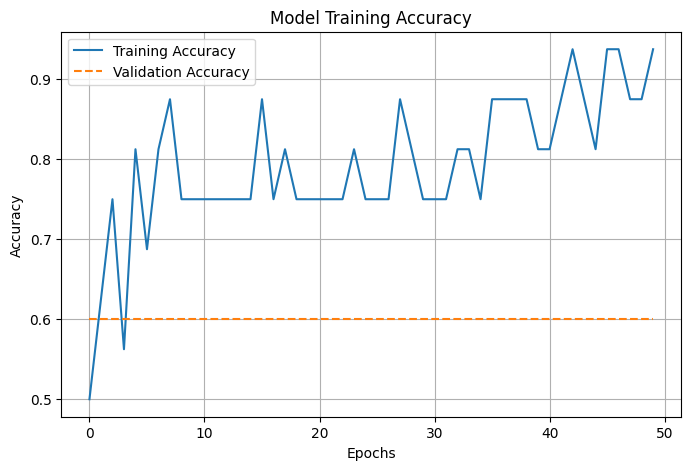

In [22]:
# Fetch available keys
available_keys = history.history.keys()
print("Available keys in history:", available_keys)

# Determine correct accuracy key
if "accuracy" in available_keys:
    accuracy_key = "accuracy"
    val_accuracy_key = "val_accuracy"
elif "acc" in available_keys:
    accuracy_key = "acc"
    val_accuracy_key = "val_acc"
else:
    raise KeyError("Accuracy key not found. Check available keys in history.")

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history[accuracy_key], label="Training Accuracy")
plt.plot(history.history[val_accuracy_key], label="Validation Accuracy", linestyle="dashed")

# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Training Accuracy")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np


In [26]:
import re

# Convert dataset to a dictionary (intent -> response)
intent_response_map = {}
for _, row in df.iterrows():
    intent_response_map[row["intent"]] = row["bot_response"]

# Define keyword mapping (intent -> list of keywords)
intent_keywords = {
    "greeting": ["hello", "hi", "hey"],
    "goodbye": ["bye", "goodbye", "see you"],
    "thanks": ["thank you", "thanks"],
    # Add more intent-keyword pairs as needed
}

# Function to get chatbot response using keyword matching
def keyword_chatbot_response(user_input):
    user_input = user_input.lower()

    # Check for matching intent based on keywords
    for intent, keywords in intent_keywords.items():
        if any(re.search(rf"\b{kw}\b", user_input) for kw in keywords):
            return intent_response_map.get(intent, "I'm not sure how to respond.")

    return "I didn't understand that. Can you rephrase?"

# Example usage
print(keyword_chatbot_response("hello there!"))
print(keyword_chatbot_response("thanks a lot"))
print(keyword_chatbot_response("bye, see you later"))


Hey! Need any help?
I'm not sure how to respond.
You're welcome! Let me know if you need anything else.


In [30]:
# Sample test dataset (user input -> expected intent)
test_data = [
    ("hello there!", "greeting"),
    ("hi", "greeting"),
    ("bye, see you later", "goodbye"),
    ("won't turn on", "problem"),  # Unknown intent
]

# Function to evaluate accuracy
def evaluate_accuracy(test_data):
    correct = 0
    total = len(test_data)

    for user_input, expected_intent in test_data:
        predicted_response = keyword_chatbot_response(user_input)

        # Find predicted intent based on response
        predicted_intent = None
        for intent, response in intent_response_map.items():
            if response == predicted_response:
                predicted_intent = intent
                break

        # Check if predicted intent matches expected intent
        if predicted_intent == expected_intent:
            correct += 1

    return correct / total  # Accuracy = Correct Predictions / Total

# Compute accuracy
accuracy = evaluate_accuracy(test_data)
print(f"Keyword-Based Chatbot Accuracy: {accuracy * 100:.2f}%")


Keyword-Based Chatbot Accuracy: 75.00%


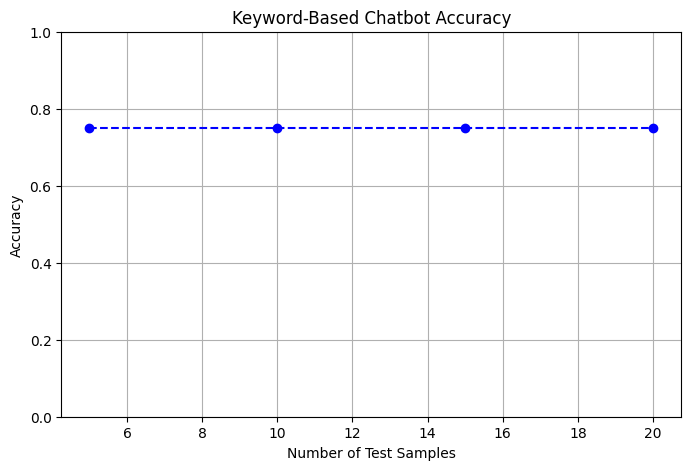

In [31]:
import matplotlib.pyplot as plt

# Define different test sets
test_sizes = [5, 10, 15, 20]
accuracies = [evaluate_accuracy(test_data * (size // len(test_data))) for size in test_sizes]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(test_sizes, accuracies, marker="o", linestyle="dashed", color="blue")

# Labels
plt.xlabel("Number of Test Samples")
plt.ylabel("Accuracy")
plt.title("Keyword-Based Chatbot Accuracy")
plt.ylim(0, 1)
plt.grid(True)

# Show plot
plt.show()


In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
import re
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [36]:
print(df.columns)


Index(['intent', 'user_message', 'bot_response', 'keywords'], dtype='object')


In [37]:
# Load dataset
file_path = "/kaggle/input/chatbotdata/chatbot_build.csv"

df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Text preprocessing function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply preprocessing
df['cleaned_text'] = df['user_message'].apply(clean_text)

# Encode target labels (intents)
label_encoder = LabelEncoder()
df['intent_label'] = label_encoder.fit_transform(df['intent'])

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
padded_sequences = pad_sequences(sequences, padding='post')

# Prepare input and output data
X = padded_sequences
y = df['intent_label'].values
vocab_size = len(tokenizer.word_index) + 1
max_length = X.shape[1]  # Get max sequence length


In [38]:
# Define model
model = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dense(len(label_encoder.classes_), activation="softmax")  # Output layer
])

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Train model
history = model.fit(X, y, epochs=20, batch_size=8, validation_split=0.2)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - accuracy: 0.3750 - loss: 1.0973 - val_accuracy: 1.0000 - val_loss: 1.0793
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7083 - loss: 1.0919 - val_accuracy: 1.0000 - val_loss: 1.0625
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7083 - loss: 1.0802 - val_accuracy: 1.0000 - val_loss: 1.0430
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6250 - loss: 1.0710 - val_accuracy: 1.0000 - val_loss: 1.0217
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7083 - loss: 1.0409 - val_accuracy: 1.0000 - val_loss: 0.9950
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5833 - loss: 1.0443 - val_accuracy: 1.0000 - val_loss: 0.9659
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6250 - loss: 1.0190 - val_accuracy: 1.0000 - val_loss: 0.9266
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5833 - loss: 0.9978 - val_accuracy: 1.0000 - val_loss: 0.8779

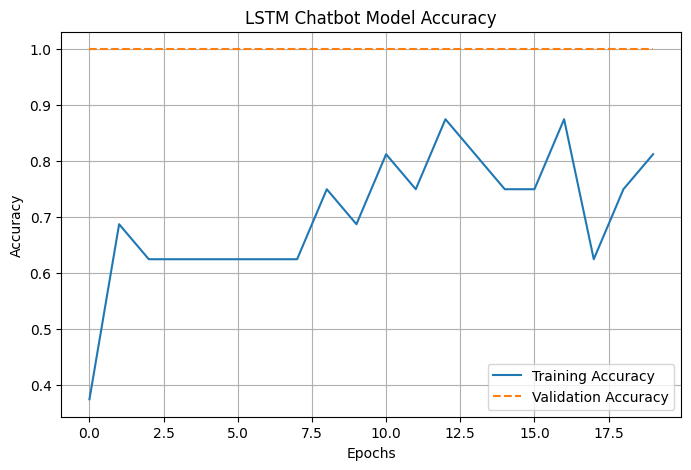

In [40]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("LSTM Chatbot Model Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [42]:
def chatbot_response(user_input):
    user_input = clean_text(user_input)  # Preprocess input
    seq = tokenizer.texts_to_sequences([user_input])  # Tokenize
    padded_seq = pad_sequences(seq, maxlen=max_length, padding='post')  # Pad sequence

    # Predict intent
    predicted_label = np.argmax(model.predict(padded_seq))
    predicted_intent = label_encoder.inverse_transform([predicted_label])[0]

    # Get response
    response = df[df["intent"] == predicted_intent]["bot_response"].values[0]
    return response

# Test chatbot
print(chatbot_response("hello"))
print(chatbot_response("camera blurry"))
print(chatbot_response("thank you!"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Goodbye! Have a great day!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Goodbye! Have a great day!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Goodbye! Have a great day!


In [43]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
# Load dataset
file_path = "/kaggle/input/chatbotdata/chatbot_build.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Check column names
print(df.columns)

# Ensure correct column names (adjust if necessary)
user_input_col = "user_message"  # Replace with actual column name if different
response_col = "bot_response"  # Replace with actual column name if different

# Text preprocessing function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply preprocessing
df["cleaned_text"] = df[user_input_col].astype(str).apply(clean_text)


Index(['intent', 'user_message', 'bot_response', 'keywords'], dtype='object')


In [47]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words="english")
X_tfidf = vectorizer.fit_transform(df["cleaned_text"])

# Function to find the best matching response
def get_response(user_input):
    user_input = clean_text(user_input)  # Preprocess input
    input_tfidf = vectorizer.transform([user_input])  # Convert to TF-IDF

    # Compute cosine similarity with dataset
    similarities = cosine_similarity(input_tfidf, X_tfidf)

    # Find the most similar response
    best_match_idx = np.argmax(similarities)
    return df[response_col].iloc[best_match_idx]

# Test chatbot
print(get_response("hello"))
print(get_response("camera blurry"))
print(get_response("Battery died"))

Hello! How can I assist you today?
Fix blurry camera issues with these steps:
1. Clean the camera lens with a soft cloth.
2. Check if there is a plastic protector covering the lens and remove it.
3. Restart the phone and try different camera modes.
4. If autofocus isn't working, update the camera app or reset camera settings.
Here are some ways to fix battery drain issues:
1. Check which apps are consuming the most battery in settings.
2. Close background apps and disable unnecessary features.
3. Reduce screen brightness and enable power-saving mode.
4. If the battery is old, consider getting a replacement.


In [48]:
correct = 0
total = len(df)

for i in range(total):
    user_input = df["cleaned_text"].iloc[i]
    predicted_response = get_response(user_input)
    actual_response = df[response_col].iloc[i]
    
    if predicted_response == actual_response:
        correct += 1

accuracy = correct / total
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 95.24%


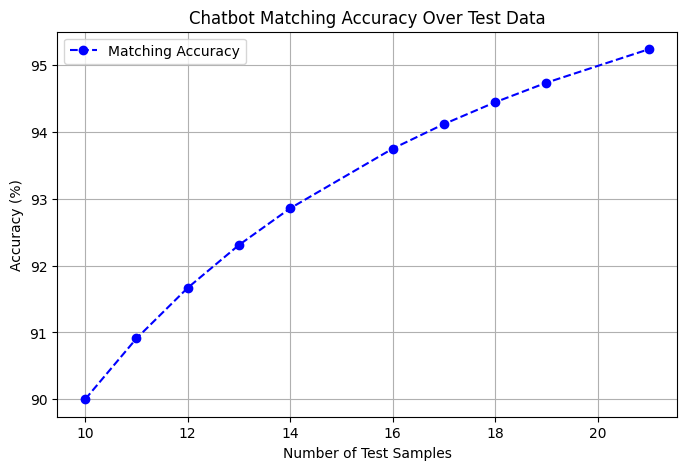

In [49]:
import matplotlib.pyplot as plt

# Simulating accuracy over different input sizes
sizes = np.linspace(10, total, 10, dtype=int)
accuracies = []

for size in sizes:
    correct = 0
    for i in range(size):
        user_input = df["cleaned_text"].iloc[i]
        predicted_response = get_response(user_input)
        actual_response = df[response_col].iloc[i]
        if predicted_response == actual_response:
            correct += 1
    accuracies.append(correct / size)

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(sizes, np.array(accuracies) * 100, marker="o", linestyle="--", color="b", label="Matching Accuracy")
plt.xlabel("Number of Test Samples")
plt.ylabel("Accuracy (%)")
plt.title("Chatbot Matching Accuracy Over Test Data")
plt.legend()
plt.grid()
plt.show()


In [50]:
import joblib
import os

# Create a directory to store the model
model_dir = "//kaggle/working/"
os.makedirs(model_dir, exist_ok=True)

# Save TF-IDF vectorizer
vectorizer_path = os.path.join(model_dir, "tfidf_vectorizer.pkl")
joblib.dump(vectorizer, vectorizer_path)

# Save DataFrame containing responses
responses_path = os.path.join(model_dir, "chatbot_responses.csv")
df[[user_input_col, response_col, "cleaned_text"]].to_csv(responses_path, index=False)

print(f"Model saved at: {model_dir}")
print(f"Vectorizer saved at: {vectorizer_path}")
print(f"Responses saved at: {responses_path}")


Model saved at: //kaggle/working/
Vectorizer saved at: //kaggle/working/tfidf_vectorizer.pkl
Responses saved at: //kaggle/working/chatbot_responses.csv
